In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [3]:
# Change this to your actual dataset path inside Google Drive
dataset_path = "/content/drive/MyDrive/Deep Learnears"

# Set up a new directory for train/val/test split
split_dataset_path = "/content/split_skin_cancer_dataset"
os.makedirs(split_dataset_path, exist_ok=True)

# Create train, val, test directories
for split in ['train', 'val', 'test']:
    for category in ['SK', 'AK', 'BCC']:
        os.makedirs(os.path.join(split_dataset_path, split, category), exist_ok=True)


In [4]:
# Function to split and move images into train/val/test folders
def split_data(class_name, split_ratios=(0.7, 0.2, 0.1)):
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)

    # Split dataset into train (70%), val (20%), test (10%)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=1/3, random_state=42)

    # Move images to respective folders
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(split_dataset_path, 'train', class_name, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(split_dataset_path, 'val', class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(split_dataset_path, 'test', class_name, img))

# Apply split for each class
for category in ['SK', 'AK', 'BCC']:
    split_data(category)


In [5]:
# Image size for EfficientNet
img_size = (600, 600)
batch_size = 32

# Data augmentation & preprocessing
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Load Train Data
train_generator = datagen.flow_from_directory(
    os.path.join(split_dataset_path, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load Validation Data
val_generator = datagen.flow_from_directory(
    os.path.join(split_dataset_path, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load Test Data
test_generator = datagen.flow_from_directory(
    os.path.join(split_dataset_path, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 666 images belonging to 3 classes.
Found 192 images belonging to 3 classes.
Found 96 images belonging to 3 classes.


In [6]:
# Early stopping: Stops training if training loss doesn't improve for 50 epochs
early_stopping = EarlyStopping(
    monitor='loss',  # Monitor training loss instead of validation loss
    patience=10 , # Stop training if no improvement for 50 epochs
    restore_best_weights=True  # Restore the best model weights
)

# Model checkpoint: Saves the best model based on validation accuracy
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_skin_cancer_model.h5',
    monitor='val_accuracy',
    save_best_only=True
)


In [7]:
# Load EfficientNetB1 without the top layer
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(600, 600, 3))

# Freeze base model layers for transfer learning
base_model.trainable = False

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(3, activation='softmax')(x)  # Change 3 to number of classes

model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=200,  # Increased epochs
    callbacks=[early_stopping, model_checkpoint]  # Apply early stopping and checkpoint
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3390 - loss: 1.1442

21/21 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.3395 - loss: 1.1443 - val_accuracy: 0.3229 - val_loss: 1.1442
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.3464 - loss: 1.1207

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 629ms/step - accuracy: 0.3467 - loss: 1.1206 - val_accuracy: 0.3750 - val_loss: 1.1104
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4245 - loss: 1.0902

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 652ms/step - accuracy: 0.4246 - loss: 1.0896 - val_accuracy: 0.4115 - val_loss: 1.0808
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.4935 - loss: 1.0448

21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 635ms/step - accuracy: 0.4922 - loss: 1.0452 - val_accuracy: 0.4531 - val_loss: 1.0547
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.5071 - loss: 1.0292

21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 624ms/step - accuracy: 0.5071 - loss: 1.0291 - val_accuracy: 0.4948 - val_loss: 1.0321
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.5316 - loss: 0.9964

21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 657ms/step - accuracy: 0.5316 - loss: 0.9967 - val_accuracy: 0.5052 - val_loss: 1.0104
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.5463 - loss: 0.9992

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 664ms/step - accuracy: 0.5472 - loss: 0.9986 - val_accuracy: 0.5417 - val_loss: 0.9918
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.6074 - loss: 0.9685

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 646ms/step - accuracy: 0.6062 - loss: 0.9686 - val_accuracy: 0.5573 - val_loss: 0.9750
Epoch 9/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.5702 - loss: 0.9610

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 643ms/step - accuracy: 0.5713 - loss: 0.9603 - val_accuracy: 0.5938 - val_loss: 0.9580
Epoch 10/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6167 - loss: 0.9405

21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 628ms/step - accuracy: 0.6158 - loss: 0.9405 - val_accuracy: 0.6094 - val_loss: 0.9421
Epoch 11/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.5865 - loss: 0.9399

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 628ms/step - accuracy: 0.5880 - loss: 0.9393 - val_accuracy: 0.6302 - val_loss: 0.9274
Epoch 12/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.6002 - loss: 0.9104

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 647ms/step - accuracy: 0.6008 - loss: 0.9105 - val_accuracy: 0.6354 - val_loss: 0.9138
Epoch 13/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6258 - loss: 0.9074

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 651ms/step - accuracy: 0.6266 - loss: 0.9068 - val_accuracy: 0.6458 - val_loss: 0.9009
Epoch 14/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.6531 - loss: 0.8633

21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 647ms/step - accuracy: 0.6528 - loss: 0.8642 - val_accuracy: 0.6615 - val_loss: 0.8888
Epoch 15/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.6607 - loss: 0.8711

21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 624ms/step - accuracy: 0.6606 - loss: 0.8711 - val_accuracy: 0.6667 - val_loss: 0.8769
Epoch 16/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 562ms/step - accuracy: 0.6592 - loss: 0.8666 - val_accuracy: 0.6667 - val_loss: 0.8653
Epoch 17/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6593 - loss: 0.8549

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 628ms/step - accuracy: 0.6597 - loss: 0.8546 - val_accuracy: 0.6719 - val_loss: 0.8545
Epoch 18/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6771 - loss: 0.8373

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 631ms/step - accuracy: 0.6772 - loss: 0.8376 - val_accuracy: 0.6875 - val_loss: 0.8442
Epoch 19/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.6826 - loss: 0.8201

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 639ms/step - accuracy: 0.6830 - loss: 0.8204 - val_accuracy: 0.6979 - val_loss: 0.8349
Epoch 20/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 560ms/step - accuracy: 0.6785 - loss: 0.8307 - val_accuracy: 0.6979 - val_loss: 0.8263
Epoch 21/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7053 - loss: 0.7978

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 637ms/step - accuracy: 0.7045 - loss: 0.7982 - val_accuracy: 0.7083 - val_loss: 0.8170
Epoch 22/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 575ms/step - accuracy: 0.6975 - loss: 0.7959 - val_accuracy: 0.7083 - val_loss: 0.8077
Epoch 23/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 558ms/step - accuracy: 0.7479 - loss: 0.7653 - val_accuracy: 0.7031 - val_loss: 0.7995
Epoch 24/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 558ms/step - accuracy: 0.7048 - loss: 0.7721 - val_accuracy: 0.7083 - val_loss: 0.7911
Epoch 25/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7240 - loss: 0.7785

21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 728ms/step - accuracy: 0.7242 - loss: 0.7780 - val_accuracy: 0.7188 - val_loss: 0.7828
Epoch 26/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 561ms/step - accuracy: 0.6808 - loss: 0.7975 - val_accuracy: 0.7188 - val_loss: 0.7753
Epoch 27/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7210 - loss: 0.7549

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 634ms/step - accuracy: 0.7213 - loss: 0.7551 - val_accuracy: 0.7292 - val_loss: 0.7678
Epoch 28/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.7331 - loss: 0.7562

21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 626ms/step - accuracy: 0.7334 - loss: 0.7559 - val_accuracy: 0.7344 - val_loss: 0.7605
Epoch 29/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 561ms/step - accuracy: 0.7178 - loss: 0.7613 - val_accuracy: 0.7344 - val_loss: 0.7538
Epoch 30/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7219 - loss: 0.7592

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 650ms/step - accuracy: 0.7225 - loss: 0.7583 - val_accuracy: 0.7396 - val_loss: 0.7470
Epoch 31/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 570ms/step - accuracy: 0.7520 - loss: 0.7179 - val_accuracy: 0.7396 - val_loss: 0.7402
Epoch 32/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 654ms/step - accuracy: 0.7471 - loss: 0.7331 - val_accuracy: 0.7396 - val_loss: 0.7337
Epoch 33/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.7350 - loss: 0.7060

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 651ms/step - accuracy: 0.7347 - loss: 0.7062 - val_accuracy: 0.7448 - val_loss: 0.7282
Epoch 34/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 578ms/step - accuracy: 0.7368 - loss: 0.7056 - val_accuracy: 0.7448 - val_loss: 0.7217
Epoch 35/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.7620 - loss: 0.6997

21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 728ms/step - accuracy: 0.7616 - loss: 0.6998 - val_accuracy: 0.7500 - val_loss: 0.7163
Epoch 36/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 563ms/step - accuracy: 0.7808 - loss: 0.6910 - val_accuracy: 0.7448 - val_loss: 0.7099
Epoch 37/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.7520 - loss: 0.6914

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 630ms/step - accuracy: 0.7523 - loss: 0.6914 - val_accuracy: 0.7552 - val_loss: 0.7045
Epoch 38/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 709ms/step - accuracy: 0.7685 - loss: 0.6715 - val_accuracy: 0.7552 - val_loss: 0.6987
Epoch 39/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 563ms/step - accuracy: 0.7788 - loss: 0.6736 - val_accuracy: 0.7552 - val_loss: 0.6936
Epoch 40/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 569ms/step - accuracy: 0.7725 - loss: 0.6645 - val_accuracy: 0.7552 - val_loss: 0.6891
Epoch 41/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7668 - loss: 0.6645

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 637ms/step - accuracy: 0.7670 - loss: 0.6642 - val_accuracy: 0.7604 - val_loss: 0.6835
Epoch 42/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 560ms/step - accuracy: 0.7619 - loss: 0.6542 - val_accuracy: 0.7604 - val_loss: 0.6789
Epoch 43/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 551ms/step - accuracy: 0.7852 - loss: 0.6404 - val_accuracy: 0.7604 - val_loss: 0.6744
Epoch 44/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 554ms/step - accuracy: 0.7849 - loss: 0.6412 - val_accuracy: 0.7604 - val_loss: 0.6696
Epoch 45/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 544ms/step - accuracy: 0.7863 - loss: 0.6500 - val_accuracy: 0.7604 - val_loss: 0.6651
Epoch 46/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8039 - loss: 0.6269

21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 629ms/step - accuracy: 0.8034 - loss: 0.6275 - val_accuracy: 0.7656 - val_loss: 0.6607
Epoch 47/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 559ms/step - accuracy: 0.8045 - loss: 0.6251 - val_accuracy: 0.7604 - val_loss: 0.6563
Epoch 48/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 562ms/step - accuracy: 0.7925 - loss: 0.6238 - val_accuracy: 0.7604 - val_loss: 0.6521
Epoch 49/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 638ms/step - accuracy: 0.7903 - loss: 0.6196 - val_accuracy: 0.7604 - val_loss: 0.6483
Epoch 50/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 550ms/step - accuracy: 0.8254 - loss: 0.6028 - val_accuracy: 0.7604 - val_loss: 0.6445
Epoch 51/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 554ms/step - accuracy: 0.7944 - loss: 0.6282 - val_accuracy: 0.7604 - val_loss: 0.6399
Epoch 52/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 556ms/step - accuracy: 0.8258 - loss: 0.6134 - val_accuracy: 0.7604 - val_loss: 0.6366
Epoch 53/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 566ms/step - accuracy: 0.8082 - loss: 0.6145 - val_a

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 629ms/step - accuracy: 0.8155 - loss: 0.5584 - val_accuracy: 0.7708 - val_loss: 0.5894
Epoch 67/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 573ms/step - accuracy: 0.8102 - loss: 0.5715 - val_accuracy: 0.7656 - val_loss: 0.5879
Epoch 68/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 657ms/step - accuracy: 0.8048 - loss: 0.5537 - val_accuracy: 0.7708 - val_loss: 0.5856
Epoch 69/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 647ms/step - accuracy: 0.8320 - loss: 0.5490 - val_accuracy: 0.7656 - val_loss: 0.5819
Epoch 70/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 561ms/step - accuracy: 0.8337 - loss: 0.5411 - val_accuracy: 0.7604 - val_loss: 0.5796
Epoch 71/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 559ms/step - accuracy: 0.8231 - loss: 0.5443 - val_accuracy: 0.7656 - val_loss: 0.5769
Epoch 72/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 563ms/step - accuracy: 0.8314 - loss: 0.5181 - val_accuracy: 0.7656 - val_loss: 0.5740
Epoch 73/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 552ms/step - accuracy: 0.8525 - loss: 0.5001 - val_a

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 634ms/step - accuracy: 0.8161 - loss: 0.5214 - val_accuracy: 0.7760 - val_loss: 0.5389
Epoch 91/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 557ms/step - accuracy: 0.8487 - loss: 0.4771 - val_accuracy: 0.7760 - val_loss: 0.5378
Epoch 92/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 529ms/step - accuracy: 0.8361 - loss: 0.4843 - val_accuracy: 0.7760 - val_loss: 0.5359
Epoch 93/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 536ms/step - accuracy: 0.8512 - loss: 0.4685 - val_accuracy: 0.7760 - val_loss: 0.5346
Epoch 94/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8532 - loss: 0.4838

21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 760ms/step - accuracy: 0.8533 - loss: 0.4831 - val_accuracy: 0.7812 - val_loss: 0.5324
Epoch 95/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 554ms/step - accuracy: 0.8097 - loss: 0.5061 - val_accuracy: 0.7760 - val_loss: 0.5317
Epoch 96/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8533 - loss: 0.4579

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 623ms/step - accuracy: 0.8523 - loss: 0.4592 - val_accuracy: 0.7865 - val_loss: 0.5299
Epoch 97/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 563ms/step - accuracy: 0.8548 - loss: 0.4644 - val_accuracy: 0.7812 - val_loss: 0.5271
Epoch 98/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 539ms/step - accuracy: 0.8320 - loss: 0.4824 - val_accuracy: 0.7812 - val_loss: 0.5256
Epoch 99/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 665ms/step - accuracy: 0.8349 - loss: 0.4807 - val_accuracy: 0.7760 - val_loss: 0.5246
Epoch 100/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 551ms/step - accuracy: 0.8545 - loss: 0.4755 - val_accuracy: 0.7865 - val_loss: 0.5232
Epoch 101/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 560ms/step - accuracy: 0.8221 - loss: 0.4750 - val_accuracy: 0.7865 - val_loss: 0.5216
Epoch 102/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 646ms/step - accuracy: 0.8626 - loss: 0.4683 - val_accuracy: 0.7865 - val_loss: 0.5207
Epoch 103/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 556ms/step - accuracy: 0.8488 - loss: 0.4437 - v

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 620ms/step - accuracy: 0.8637 - loss: 0.4485 - val_accuracy: 0.7917 - val_loss: 0.5164
Epoch 106/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 532ms/step - accuracy: 0.8370 - loss: 0.4647 - val_accuracy: 0.7917 - val_loss: 0.5148
Epoch 107/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 552ms/step - accuracy: 0.8645 - loss: 0.4257 - val_accuracy: 0.7917 - val_loss: 0.5133
Epoch 108/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 556ms/step - accuracy: 0.8512 - loss: 0.4404 - val_accuracy: 0.7812 - val_loss: 0.5112
Epoch 109/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 547ms/step - accuracy: 0.8245 - loss: 0.4709 - val_accuracy: 0.7865 - val_loss: 0.5104
Epoch 110/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 546ms/step - accuracy: 0.8782 - loss: 0.4276 - val_accuracy: 0.7917 - val_loss: 0.5095
Epoch 111/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8472 - loss: 0.4565

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 638ms/step - accuracy: 0.8475 - loss: 0.4560 - val_accuracy: 0.7969 - val_loss: 0.5091
Epoch 112/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 554ms/step - accuracy: 0.8531 - loss: 0.4295 - val_accuracy: 0.7865 - val_loss: 0.5077
Epoch 113/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.8589 - loss: 0.4614 - val_accuracy: 0.7917 - val_loss: 0.5069
Epoch 114/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 558ms/step - accuracy: 0.8507 - loss: 0.4339 - val_accuracy: 0.7969 - val_loss: 0.5059
Epoch 115/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 561ms/step - accuracy: 0.8599 - loss: 0.4472 - val_accuracy: 0.7917 - val_loss: 0.5042
Epoch 116/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 546ms/step - accuracy: 0.8592 - loss: 0.4275 - val_accuracy: 0.7969 - val_loss: 0.5036
Epoch 117/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 649ms/step - accuracy: 0.8638 - loss: 0.4314 - val_accuracy: 0.7969 - val_loss: 0.5015
Epoch 118/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 544ms/step - accuracy: 0.8481 - loss: 0.4647 

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 619ms/step - accuracy: 0.8697 - loss: 0.4189 - val_accuracy: 0.8021 - val_loss: 0.4876
Epoch 132/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 566ms/step - accuracy: 0.8805 - loss: 0.4233 - val_accuracy: 0.8021 - val_loss: 0.4866
Epoch 133/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 563ms/step - accuracy: 0.8608 - loss: 0.4134 - val_accuracy: 0.8021 - val_loss: 0.4865
Epoch 134/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 548ms/step - accuracy: 0.8692 - loss: 0.4144 - val_accuracy: 0.8021 - val_loss: 0.4848
Epoch 135/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 557ms/step - accuracy: 0.8800 - loss: 0.3989 - val_accuracy: 0.8021 - val_loss: 0.4835
Epoch 136/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 566ms/step - accuracy: 0.8669 - loss: 0.3942 - val_accuracy: 0.7969 - val_loss: 0.4829
Epoch 137/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 652ms/step - accuracy: 0.8731 - loss: 0.4091 - val_accuracy: 0.8021 - val_loss: 0.4829
Epoch 138/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8575 - loss: 0.4105

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 619ms/step - accuracy: 0.8577 - loss: 0.4100 - val_accuracy: 0.8073 - val_loss: 0.4810
Epoch 139/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 647ms/step - accuracy: 0.8518 - loss: 0.3996 - val_accuracy: 0.8073 - val_loss: 0.4803
Epoch 140/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 545ms/step - accuracy: 0.8763 - loss: 0.3949 - val_accuracy: 0.8021 - val_loss: 0.4807
Epoch 141/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 644ms/step - accuracy: 0.8605 - loss: 0.4160 - val_accuracy: 0.8021 - val_loss: 0.4796
Epoch 142/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 563ms/step - accuracy: 0.8929 - loss: 0.3953 - val_accuracy: 0.8021 - val_loss: 0.4778
Epoch 143/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 569ms/step - accuracy: 0.8732 - loss: 0.3862 - val_accuracy: 0.8021 - val_loss: 0.4774
Epoch 144/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 572ms/step - accuracy: 0.8949 - loss: 0.3744 - val_accuracy: 0.8021 - val_loss: 0.4769
Epoch 145/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 560ms/step - accuracy: 0.8703 - loss: 0.3900 

21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 631ms/step - accuracy: 0.8817 - loss: 0.3693 - val_accuracy: 0.8125 - val_loss: 0.4699
Epoch 155/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 564ms/step - accuracy: 0.8784 - loss: 0.3701 - val_accuracy: 0.8073 - val_loss: 0.4682
Epoch 156/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 563ms/step - accuracy: 0.8773 - loss: 0.3795 - val_accuracy: 0.8125 - val_loss: 0.4661
Epoch 157/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 557ms/step - accuracy: 0.8694 - loss: 0.4058 - val_accuracy: 0.8125 - val_loss: 0.4678
Epoch 158/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8954 - loss: 0.3459

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 650ms/step - accuracy: 0.8947 - loss: 0.3470 - val_accuracy: 0.8177 - val_loss: 0.4656
Epoch 159/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 561ms/step - accuracy: 0.8730 - loss: 0.3854 - val_accuracy: 0.8073 - val_loss: 0.4664
Epoch 160/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 558ms/step - accuracy: 0.8773 - loss: 0.3824 - val_accuracy: 0.8073 - val_loss: 0.4656
Epoch 161/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 647ms/step - accuracy: 0.8780 - loss: 0.3732 - val_accuracy: 0.8125 - val_loss: 0.4650
Epoch 162/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 562ms/step - accuracy: 0.8790 - loss: 0.3686 - val_accuracy: 0.8073 - val_loss: 0.4648
Epoch 163/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 547ms/step - accuracy: 0.8686 - loss: 0.3924 - val_accuracy: 0.8177 - val_loss: 0.4634
Epoch 164/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 544ms/step - accuracy: 0.8916 - loss: 0.3414 - val_accuracy: 0.8073 - val_loss: 0.4635
Epoch 165/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 583ms/step - accuracy: 0.9008 - loss: 0.3431 

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 625ms/step - accuracy: 0.9000 - loss: 0.3380 - val_accuracy: 0.8229 - val_loss: 0.4537
Epoch 181/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 558ms/step - accuracy: 0.8799 - loss: 0.3788 - val_accuracy: 0.8125 - val_loss: 0.4522
Epoch 182/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 567ms/step - accuracy: 0.8768 - loss: 0.3564 - val_accuracy: 0.8229 - val_loss: 0.4528
Epoch 183/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 559ms/step - accuracy: 0.8892 - loss: 0.3463 - val_accuracy: 0.8177 - val_loss: 0.4527
Epoch 184/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 574ms/step - accuracy: 0.8813 - loss: 0.3589 - val_accuracy: 0.8229 - val_loss: 0.4523
Epoch 185/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 561ms/step - accuracy: 0.8938 - loss: 0.3553 - val_accuracy: 0.8229 - val_loss: 0.4522
Epoch 186/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 561ms/step - accuracy: 0.8774 - loss: 0.3587 - val_accuracy: 0.8229 - val_loss: 0.4518
Epoch 187/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 655ms/step - accuracy: 0.8960 - loss: 0.3366 

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 642ms/step - accuracy: 0.8893 - loss: 0.3361 - val_accuracy: 0.8281 - val_loss: 0.4458
Epoch 199/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 565ms/step - accuracy: 0.8956 - loss: 0.3206 - val_accuracy: 0.8177 - val_loss: 0.4450
Epoch 200/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 538ms/step - accuracy: 0.8878 - loss: 0.3278 - val_accuracy: 0.8177 - val_loss: 0.4439


In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")




3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - accuracy: 0.7773 - loss: 0.5464
Test Accuracy: 0.7812


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report



In [11]:
# Get true labels and predictions
y_true = test_generator.classes  # True labels
y_pred_probs = model.predict(test_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 363ms/step


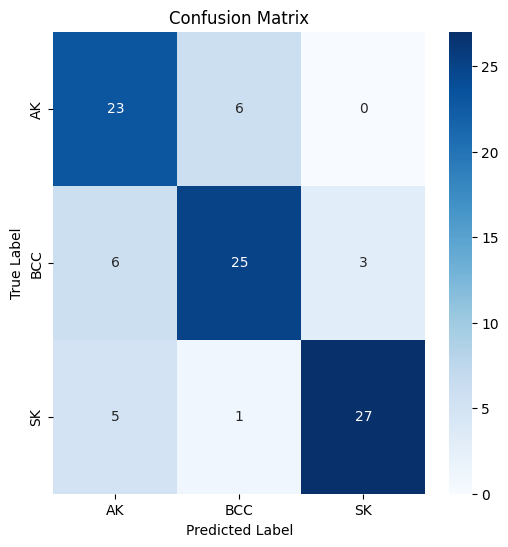

In [12]:
# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [13]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

          AK       0.68      0.79      0.73        29
         BCC       0.78      0.74      0.76        34
          SK       0.90      0.82      0.86        33

    accuracy                           0.78        96
   macro avg       0.79      0.78      0.78        96
weighted avg       0.79      0.78      0.78        96



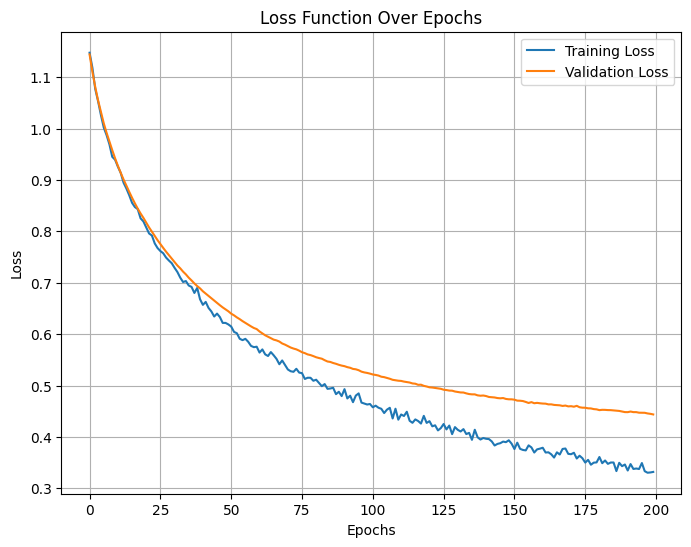

In [14]:
# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function Over Epochs')
plt.legend()
plt.grid()
plt.show()


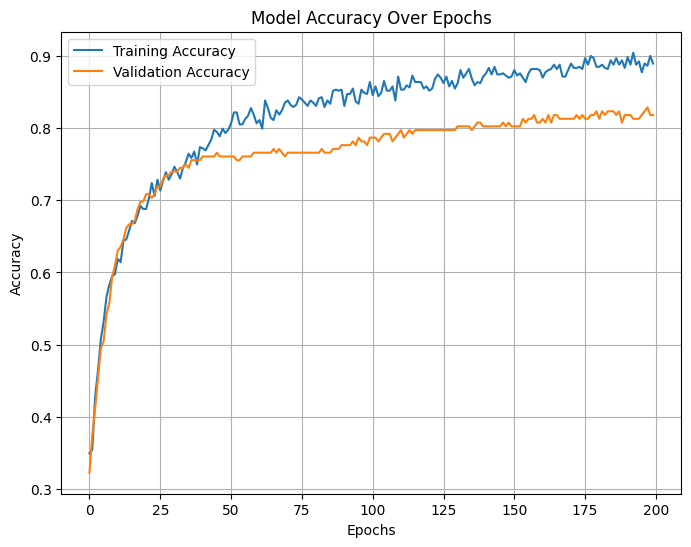

In [15]:
# Plot training & validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()
